# Analysis of Karate Club Graph using Spectral Modularity

This notebook analyzes the famous Zachary's Karate Club graph. We will use a recursive spectral partitioning algorithm to identify communities based on modularity optimization.

___
## 1. Imports and Setup

Importing all necessary libraries.

In [22]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from numpy.linalg import eigh
import math

___
## 2. Load Data and Initial Analysis

Loading the Karate Club graph from `networkx` and printing some basic statistics.

In [23]:
G = nx.karate_club_graph()

print("Karate Club Graph Statistics:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Average degree: {2 * G.number_of_edges() / G.number_of_nodes():.2f}")
print(f"Is connected: {nx.is_connected(G)}")


Karate Club Graph Statistics:
Number of nodes: 34
Number of edges: 78
Average degree: 4.59
Is connected: True


### Initial Visualization

Visualizing the initial structure of the graph using a spring layout.

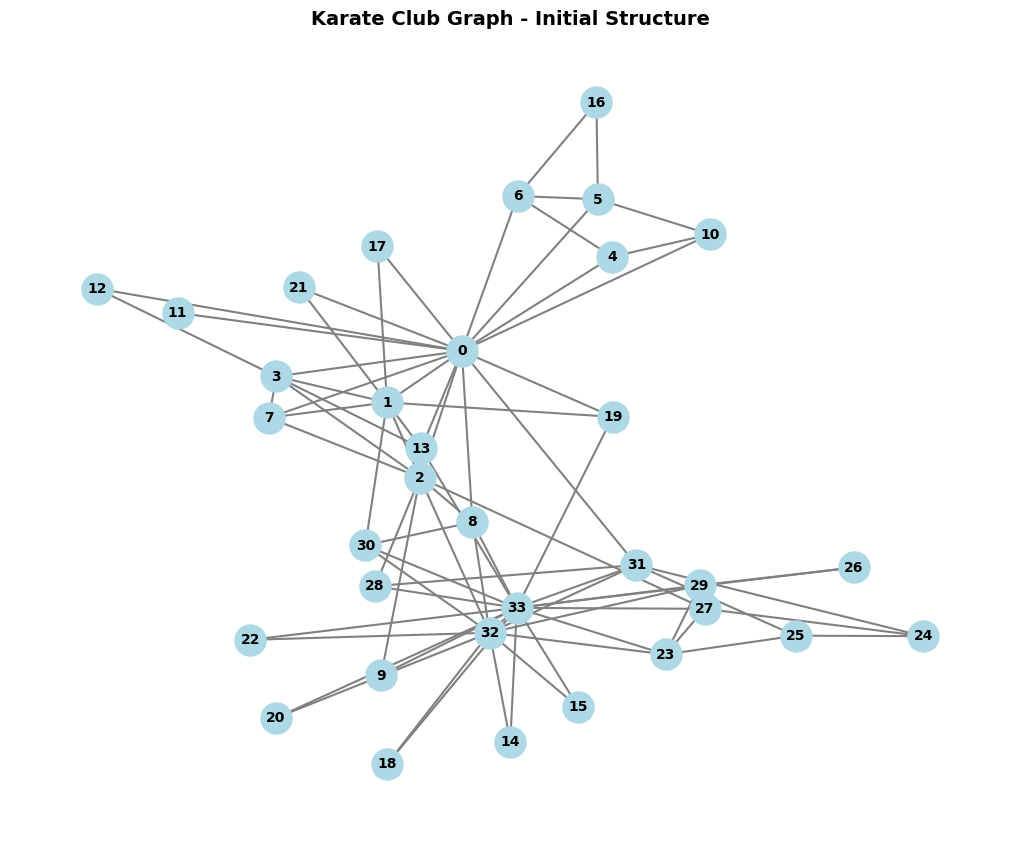

In [24]:
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=500, font_size=10, font_weight='bold',
        edge_color='gray', width=1.5)
plt.title("Karate Club Graph - Initial Structure", fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

___
## 3. Core Algorithm: Recursive Spectral Partitioning

Defining the functions for our community detection algorithm.

1.  `compute_modularity_matrix`: Calculates the modularity matrix `B` for a given graph or subgraph.
2.  `spectral_partition`: Performs a single split on a community by finding the leading eigenvector of its modularity matrix.
3.  `recursive_spectral_modularity`: Applies the partitioning recursively until no further beneficial splits (based on modularity gain) can be made.


### Task 1: Modularity Matrix

**Modularity matrix** is calculated per split made for the subgraphs using formula: $B = A - \frac{kk^T}{2m}$, where A is the adjacency matrix, k is the degree vector and m is the edges


In [25]:
def calculate_modularity_matrix(G):
    nodes = list(G.nodes())
    A = nx.adjacency_matrix(G, nodelist=nodes, dtype=float).todense()
    k = A.sum(axis=1)
    m = A.sum() / 2.0   #Number of edges of subgraph
    P = np.outer(k, k) / (2.0 * m) if m > 0 else np.zeros_like(A)
    B = A - P
    return B, nodes, m, k


### Task 2: Spectral Partition

Performing spectral partition by using the following formulas:- sub refers to the subgraphs of the splits

1. **Modularity Matrix**: $B_{sub} = A_{sub} - \frac{k_{sub} k_{sub}^T}{2m_{sub}}$

2. **Leading Eigenpair**: $B_{sub} u_1 = \lambda_1 u_1$ (where $\lambda_1$ is the largest eigenvalue)

3. **Stopping Rule**: If $\lambda_1 \leq 0$, stop splitting

4. **Node Assignment**: $s_i = \text{sign}((u_1)_i) \in \{-1, +1\}$

5. **Modularity Gain**: $\Delta Q = \frac{s^T B_{sub} s}{4m_{sub}}$

In [26]:
def spectral_bipartition(B, nodes):
    vals, vecs = eigh(B)
    lambda1 = vals[-1]
    u1 = vecs[:, -1]
    if lambda1 <= 0:
        return None, None, float(lambda1), u1
    sign_mask = u1 > 0
    group_pos = [nodes[i] for i in range(len(nodes)) if sign_mask[i]]
    group_neg = [nodes[i] for i in range(len(nodes)) if not sign_mask[i]]
    if len(group_pos) == 0 or len(group_neg) == 0:
        return None, None, float(lambda1), u1
    return group_pos, group_neg, float(lambda1), u1


In [27]:
def modularity_from_B(B, s, m):
    if m <= 0:
        return 0.0
    return float((s.T @ (B @ s)) / (4.0 * m))
def delta_Q_sign_split(B, m, u1):
    s = np.where(u1 > 0, 1.0, -1.0)
    return modularity_from_B(B, s, m)


Degfing the Recursive modularity function that returns final community and list of all community at each partition.

In [28]:
def recursive_spectral_modularity(G, max_iter=20):
    # current partition: list of communities (each is a list of nodes)
    current_comms = [list(G.nodes())]

    # iterations: partition after each successful split
    iterations = []
    # initial state: all nodes in one community
    iterations.append([list(c) for c in current_comms])

    i = 0
    while i < max_iter:
        split_occurred = False

        # we iterate over a *copy* because we'll modify current_comms
        for community in current_comms.copy():
            # stopping rule for very small communities
            if len(community) <= 2:
                continue

            SG = G.subgraph(community).copy()
            B, nodes, m, k = calculate_modularity_matrix(SG)
            group_pos, group_neg, lambda1, u1 = spectral_bipartition(B, nodes)

            # if spectral bipartition fails, skip
            if group_pos is None or len(group_pos) == 0 or len(group_neg) == 0:
                continue

            Q = delta_Q_sign_split(B, m, u1)

            if Q > 0:
                # log the split
                print(
                    f"Split community of size {len(community)} "
                    f"into {len(group_pos)} and {len(group_neg)} nodes "
                    f"(modularity gain: {Q:.4f})"
                )

                # 1) removing old community from current partition
                current_comms.remove(community)

                # 2) adding the two new communities
                current_comms.append(group_pos)
                current_comms.append(group_neg)

                # 3) recording the new partition *after this split*
                iterations.append([list(c) for c in current_comms])

                split_occurred = True

        if not split_occurred:
            break

        i += 1

    final_comms = current_comms
    return final_comms, iterations


In [29]:
print("\nStarting partitioning...")
final_comms,iterations = recursive_spectral_modularity(G)
print(f"Found {len(iterations)} communities.")
print("Final communities:")
print(final_comms)


Starting partitioning...
Split community of size 34 into 16 and 18 nodes (modularity gain: 0.4036)
Split community of size 16 into 9 and 7 nodes (modularity gain: 0.2534)
Split community of size 18 into 6 and 12 nodes (modularity gain: 0.2159)
Split community of size 9 into 2 and 7 nodes (modularity gain: 0.0510)
Split community of size 7 into 3 and 4 nodes (modularity gain: 0.1667)
Split community of size 6 into 3 and 3 nodes (modularity gain: 0.1368)
Split community of size 12 into 2 and 10 nodes (modularity gain: 0.0988)
Split community of size 4 into 2 and 2 nodes (modularity gain: 0.0455)
Split community of size 10 into 2 and 8 nodes (modularity gain: 0.0459)
Split community of size 8 into 5 and 3 nodes (modularity gain: 0.0354)
Found 11 communities.
Final communities:
[[3, 12], [1, 2, 7, 13, 17, 19, 21], [5, 6, 16], [25, 28, 31], [23, 24, 27], [26, 29], [10, 4], [0, 11], [8, 30], [33, 9, 15, 18, 22], [32, 14, 20]]


### Task 3: Visualization of Community Evolution

Visualize the graph of evolution of communities at each iteration.


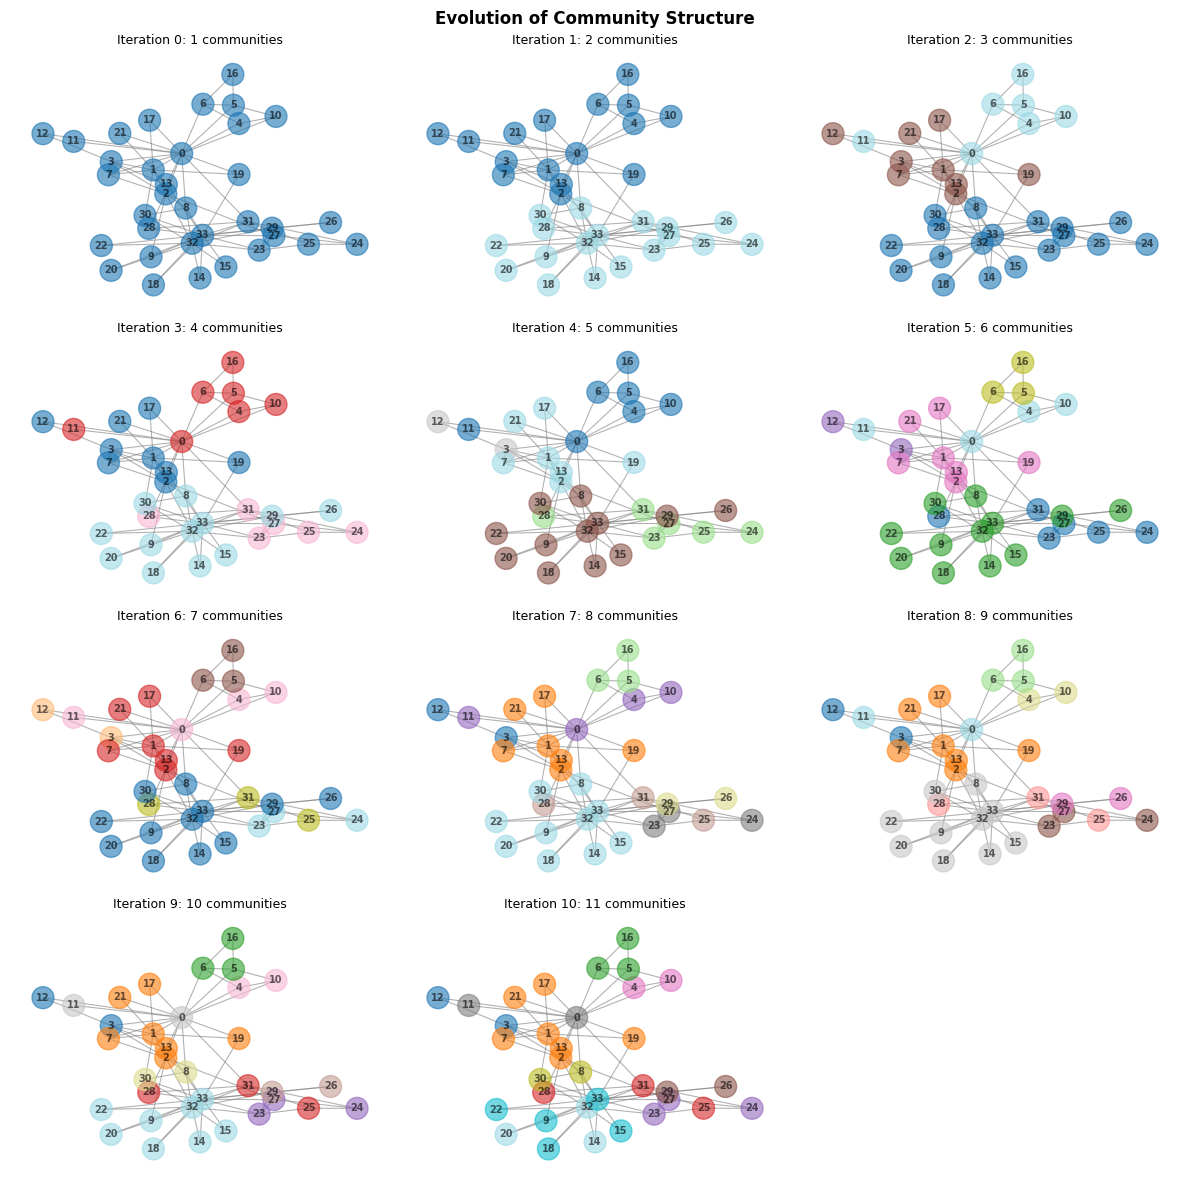

In [30]:
def visualize_communities_evolution(G, iterations, pos):
    n_iterations = len(iterations)

    # choose a reasonable number of columns (e.g. 3)
    n_cols = 3 if n_iterations >= 3 else n_iterations
    n_rows = math.ceil(n_iterations / n_cols)

    # smaller panels: width/height per subplot is modest
    fig_width = 4 * n_cols
    fig_height = 3 * n_rows
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))

    # axes may be a single Axes if n_rows == n_cols == 1
    if n_rows * n_cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    # draw each snapshot
    for idx, communities in enumerate(iterations):
        ax = axes[idx]

        # color map for communities
        node_colors = {}
        colors = plt.get_cmap('tab20')(np.linspace(0, 1, len(communities)))

        for comm_idx, community in enumerate(communities):
            for node in community:
                node_colors[node] = colors[comm_idx]

        # fallback color if any node missing (should not happen)
        default_color = (0.8, 0.8, 0.8, 1.0)
        node_color_list = [node_colors.get(node, default_color) for node in G.nodes()]

        nx.draw(
            G,
            pos,
            ax=ax,
            with_labels=True,
            node_color=node_color_list,
            node_size=250,         
            font_size=7,           
            font_weight="bold",
            edge_color="gray",
            width=0.8,
            alpha=0.6,
        )

        ax.set_title(
            f"Iteration {idx}: {len(communities)} communities",
            fontsize=9
        )
        ax.axis("off")

    # hide any unused subplots
    for j in range(n_iterations, n_rows * n_cols):
        axes[j].axis("off")

    plt.suptitle(
        "Evolution of Community Structure",
        fontsize=12,
        fontweight="bold",
        y=0.98
    )
    plt.tight_layout()
    plt.show()

visualize_communities_evolution(G, iterations, pos)


___
## 4. Node Metrics Analysis

4 seperate metrics are calculated:-
1. **Degree Centrality**: $C_D(i) = \frac{k_i}{n-1}$ — Direct connectivity measure

2. **Betweenness Centrality**: $C_B(i) = \sum_{s \neq i \neq t} \frac{\sigma_{st}(i)}{\sigma_{st}}$ — Bridge/broker measure

3. **Closeness Centrality**: $C_C(i) = \frac{n-1}{\sum_{j \neq i} d(i,j)}$ — Speed of information spread

4. **Clustering Coefficient**: $C(i) = \frac{2T(i)}{k_i(k_i-1)}$ — Local cohesion measure

All metrics are computed using NetworkX built-in functions on the complete graph after each community split.

In [31]:
def compute_node_metrics(G):
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    clustering_coefficient = nx.clustering(G)

    metrics = {}
    for node in G.nodes():
        metrics[node] = {
            'degree_centrality': degree_centrality[node],
            'betweenness_centrality': betweenness_centrality[node],
            'closeness_centrality': closeness_centrality[node],
            'clustering_coefficient': clustering_coefficient[node],
        }
    return metrics


def compute_metrics_per_iteration(G, iterations):
    """
    Compute metrics for each node considering their community membership,
    returning a list of per-node dicts, one dict per node per iteration.
    """
    all_metrics = []

    for iter_idx, communities in enumerate(iterations):
        # Map node -> community id
        node_to_community = {}
        for comm_idx, community in enumerate(communities):
            for node in community:
                node_to_community[node] = comm_idx

        # Compute centrality metrics for this iteration
        metrics = compute_node_metrics(G)
        n_communities = len(communities)

        # Build a flat list of records (like DataFrame rows)
        for node in G.nodes():
            record = {
                'node': node,
                'iteration': iter_idx,
                'community': node_to_community.get(node, None),
                'n_communities': n_communities,
                'degree_centrality': metrics[node]['degree_centrality'],
                'betweenness_centrality': metrics[node]['betweenness_centrality'],
                'closeness_centrality': metrics[node]['closeness_centrality'],
                'clustering_coefficient': metrics[node]['clustering_coefficient'],
            }
            all_metrics.append(record)

    return all_metrics


Printing the metrics for first 5 and last 5 nodes for first and last iterations.

In [32]:
# Compute metrics across iterations
metrics_evolution = compute_metrics_per_iteration(G, iterations)

# Display sample of the metrics (first and last iteration, first 5 nodes each)
print("Sample of Node Metrics first and last 5 nodes of First and Last Iteration:")

print("\nFirst Iteration (All nodes in one community):")
first_iter_top = [r for r in metrics_evolution if r['iteration'] == 0][:5]
first_iter_bottom = [r for r in metrics_evolution if r['iteration'] == 0][-5:]

for r in first_iter_top + first_iter_bottom:
    print(r)

print("\nLast Iteration:")
last_iter_index = len(iterations) - 1
last_iter_top = [r for r in metrics_evolution if r['iteration'] == last_iter_index][:5]
last_iter_bottom = [r for r in metrics_evolution if r['iteration'] == last_iter_index][-5:]
for r in last_iter_top + last_iter_bottom:
    print(r)

Sample of Node Metrics first and last 5 nodes of First and Last Iteration:

First Iteration (All nodes in one community):
{'node': 0, 'iteration': 0, 'community': 0, 'n_communities': 1, 'degree_centrality': 0.48484848484848486, 'betweenness_centrality': 0.43763528138528146, 'closeness_centrality': 0.5689655172413793, 'clustering_coefficient': 0.15}
{'node': 1, 'iteration': 0, 'community': 0, 'n_communities': 1, 'degree_centrality': 0.2727272727272727, 'betweenness_centrality': 0.053936688311688304, 'closeness_centrality': 0.4852941176470588, 'clustering_coefficient': 0.3333333333333333}
{'node': 2, 'iteration': 0, 'community': 0, 'n_communities': 1, 'degree_centrality': 0.30303030303030304, 'betweenness_centrality': 0.14365680615680618, 'closeness_centrality': 0.559322033898305, 'clustering_coefficient': 0.24444444444444444}
{'node': 3, 'iteration': 0, 'community': 0, 'n_communities': 1, 'degree_centrality': 0.18181818181818182, 'betweenness_centrality': 0.011909271284271283, 'closenes

Ploting various metrics.


In [33]:
def plot_metrics_evolution(metrics_evolution, iterations):
    """
    Plot how metrics evolve across iterations for all nodes,
    with each metric in a separate figure window.
    """
    metric_names = [
        'degree_centrality',
        'betweenness_centrality',
        'closeness_centrality',
        'clustering_coefficient'
    ]

    # Precompute: set of all nodes and max iteration
    nodes = sorted({rec['node'] for rec in metrics_evolution})
    max_iter = max(rec['iteration'] for rec in metrics_evolution)

    for metric in metric_names:
        # New window for each metric
        plt.figure(figsize=(8, 6))

        # For each node, extract its time series for this metric
        for node in nodes:
            node_records = [rec for rec in metrics_evolution
                            if rec['node'] == node]
            node_records.sort(key=lambda r: r['iteration'])

            x = [r['iteration'] for r in node_records]
            y = [r[metric] for r in node_records]

            plt.plot(x, y, marker='o', linewidth=1,
                     label=f'Node {node}')

        plt.xlabel('Iteration', fontsize=11)
        plt.ylabel(metric.replace('_', ' ').title(), fontsize=11)
        plt.title(
            f'Evolution of {metric.replace("_", " ").title()}',
            fontsize=12, fontweight='bold'
        )
        plt.grid(True, alpha=0.3)
        plt.xticks(range(max_iter + 1))

        # Comment out if too many nodes
        plt.legend(loc='best', fontsize=8)

        # Optional: tight layout for each figure
        plt.tight_layout()

    # Show all figures at once
    plt.show()

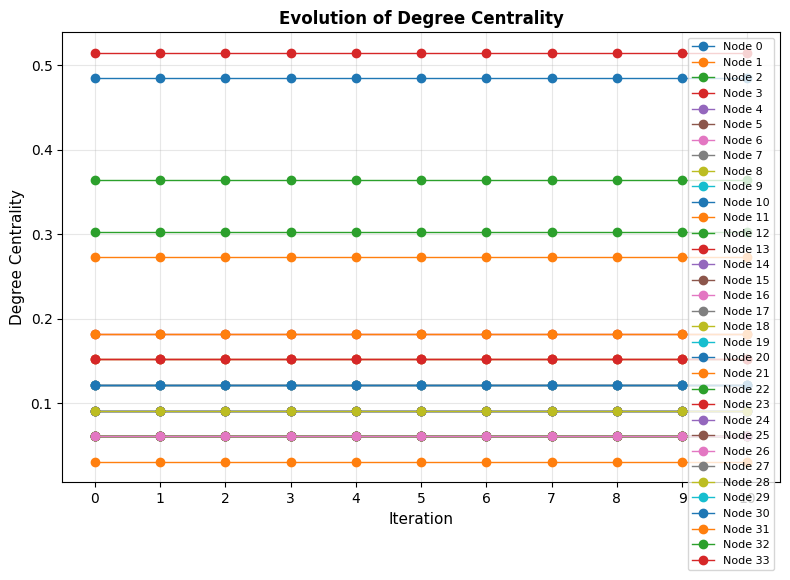

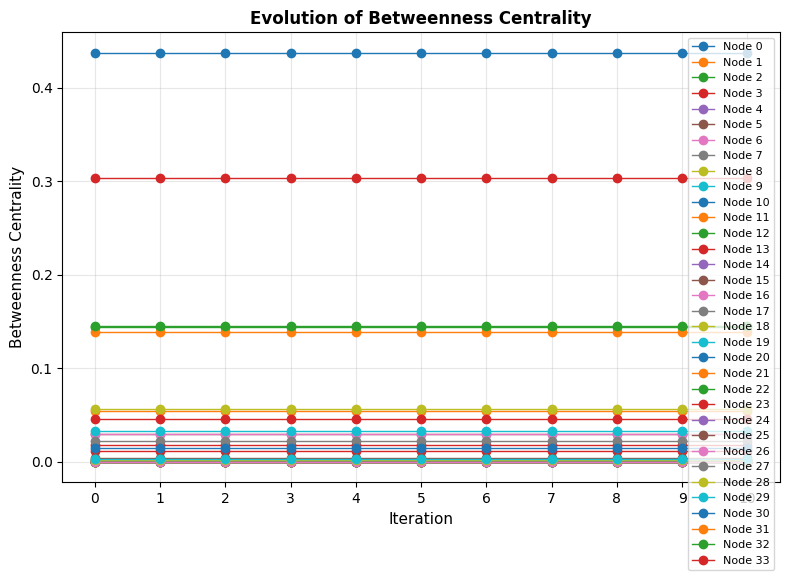

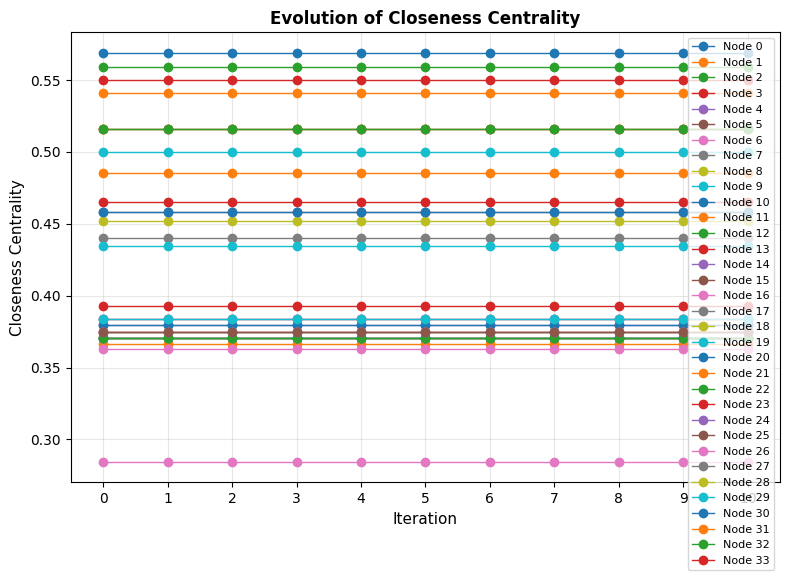

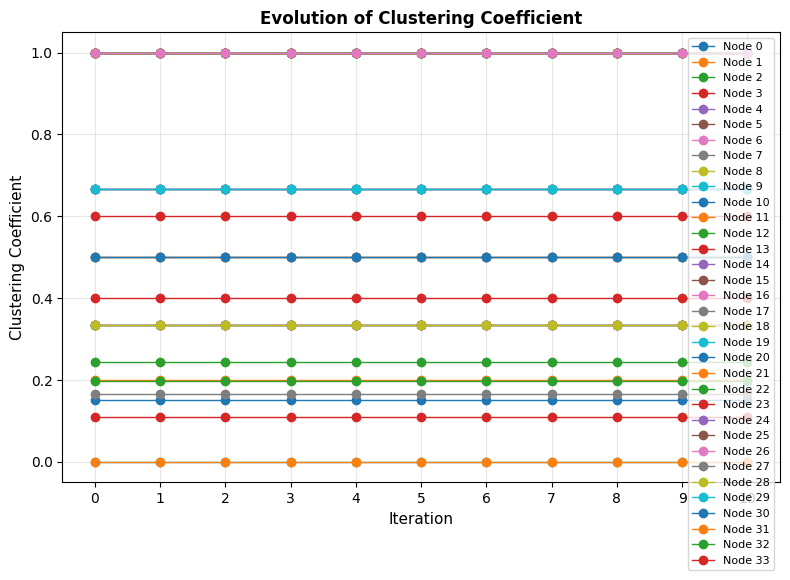

In [34]:
metrics_evolution = compute_metrics_per_iteration(G, iterations)
plot_metrics_evolution(metrics_evolution, iterations)


___
## 5. Modularity Score Calculation and Plotting

In [35]:
def compute_modularity_score(G, communities):
    # NetworkX's modularity function uses the global graph G
    
    return nx.algorithms.community.quality.modularity(G, communities)

def plot_modularity_evolution(iteration_history, modularity_scores):

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(range(len(iteration_history)), modularity_scores, 
            marker='o', linewidth=2, markersize=8, color='darkblue')
    ax.set_xlabel('Iteration', fontsize=12)
    ax.set_ylabel('Modularity Score', fontsize=12)
    ax.set_title('Evolution of Modularity Score', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(len(iteration_history)))

    for i, score in enumerate(modularity_scores):
        ax.annotate(f'{score:.3f}', (i, score), 
                   textcoords="offset points", xytext=(0,10), 
                   ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()

Initial modularity (1 community): 0.0000
Final modularity (11 communities): 0.2560
Optimal modularity: 0.4211 at iteration 3


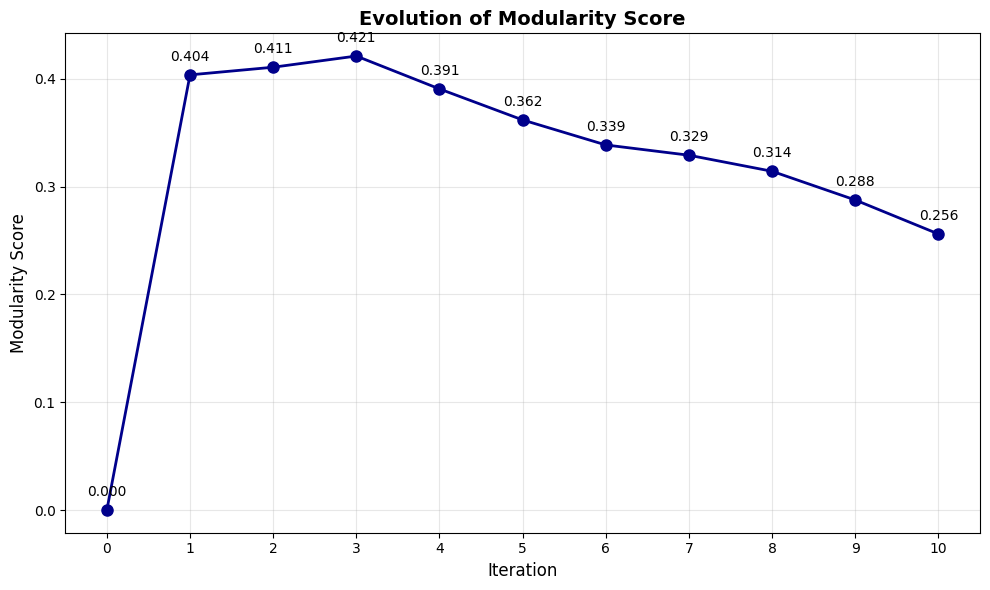

In [36]:
modularity_scores = []
for communities in iterations:
    # We calculate modularity score based on the original graph
    score = compute_modularity_score(G, communities)
    modularity_scores.append(score)

print(f"Initial modularity (1 community): {modularity_scores[0]:.4f}")
print(f"Final modularity ({len(iterations)} communities): {modularity_scores[-1]:.4f}")
print(f"Optimal modularity: {max(modularity_scores):.4f} at iteration {np.argmax(modularity_scores)}")

plot_modularity_evolution(iterations, modularity_scores)

___
## 6. Key Node Identification

Identifying "hub" nodes — nodes that remain central across the partitioning process. 
Nodes will be identified based of their rank in the top 5 for at least two different centrality metrics (averaged across all iterations).

In [37]:
def identify_key_nodes(metrics_evolution, top_k=5, hub_threshold=2):
    # 1. accumulate sums and counts per node
    sums = {}   
    counts = {} 

    metric_names = [
        "degree_centrality",
        "betweenness_centrality",
        "closeness_centrality",
        "clustering_coefficient",
    ]

    for row in metrics_evolution:
        node = row["node"]

        if node not in sums:
            sums[node] = {}
            for m in metric_names:
                sums[node][m] = 0.0
            counts[node] = 0

        for m in metric_names:
            sums[node][m] += float(row[m])
        counts[node] += 1

    # 2. compute averages per node
    avg_metrics = {} 
    for node in sums:
        avg_metrics[node] = {}
        for m in metric_names:
            if counts[node] > 0:
                avg_metrics[node][m] = round(sums[node][m] / counts[node], 4)
            else:
                avg_metrics[node][m] = 0.0

    # 3. find top_k nodes per metric
    key_nodes = {}  # metric -> [node_ids]

    for m in metric_names:
        # build list of (node, avg_value) pairs
        pairs = []
        for node in avg_metrics:
            pairs.append((node, avg_metrics[node][m]))

        # sort by value descending
        pairs.sort(key=lambda x: x[1], reverse=True)

        # take top_k node ids
        top_nodes = []
        for i in range(min(top_k, len(pairs))):
            top_nodes.append(pairs[i][0])

        key_nodes[m] = top_nodes

    # 4. count how many metric top-lists each node appears in
    appearances = {} 
    for metric in key_nodes:
        nodes_list = key_nodes[metric]
        for node in nodes_list:
            if node not in appearances:
                appearances[node] = 0
            appearances[node] += 1

    # 5. hub nodes: appear in at least hub_threshold different metrics' top_k
    hub_nodes = []
    for node in appearances:
        if appearances[node] >= hub_threshold:
            hub_nodes.append(node)

    return avg_metrics, key_nodes, hub_nodes


### Key Node Analysis

In [38]:
# Identify key nodes
avg_metrics, key_nodes, hub_nodes = identify_key_nodes(
    metrics_evolution,
    top_k=5,
    hub_threshold=2
)

print("KEY NODES ANALYSIS")

print("\nTop 5 nodes by each metric (averaged across iterations):")
for metric, nodes in key_nodes.items():
    print(f"\n{metric.replace('_', ' ').title()}:")
    # show top 3 for brevity
    for node in nodes[:3]:
        value = avg_metrics[node][metric]
        print(f"  Node {node}: {value:.4f}")

print(f"\nHub nodes (appearing in multiple top-5 lists): {hub_nodes}")


KEY NODES ANALYSIS

Top 5 nodes by each metric (averaged across iterations):

Degree Centrality:
  Node 33: 0.5152
  Node 0: 0.4848
  Node 32: 0.3636

Betweenness Centrality:
  Node 0: 0.4376
  Node 33: 0.3041
  Node 32: 0.1452

Closeness Centrality:
  Node 0: 0.5690
  Node 2: 0.5593
  Node 33: 0.5500

Clustering Coefficient:
  Node 7: 1.0000
  Node 12: 1.0000
  Node 14: 1.0000

Hub nodes (appearing in multiple top-5 lists): [33, 0, 32, 2, 31]


Plotting the final communities with highlighting top 5 nodes otherwise known as Hubs.

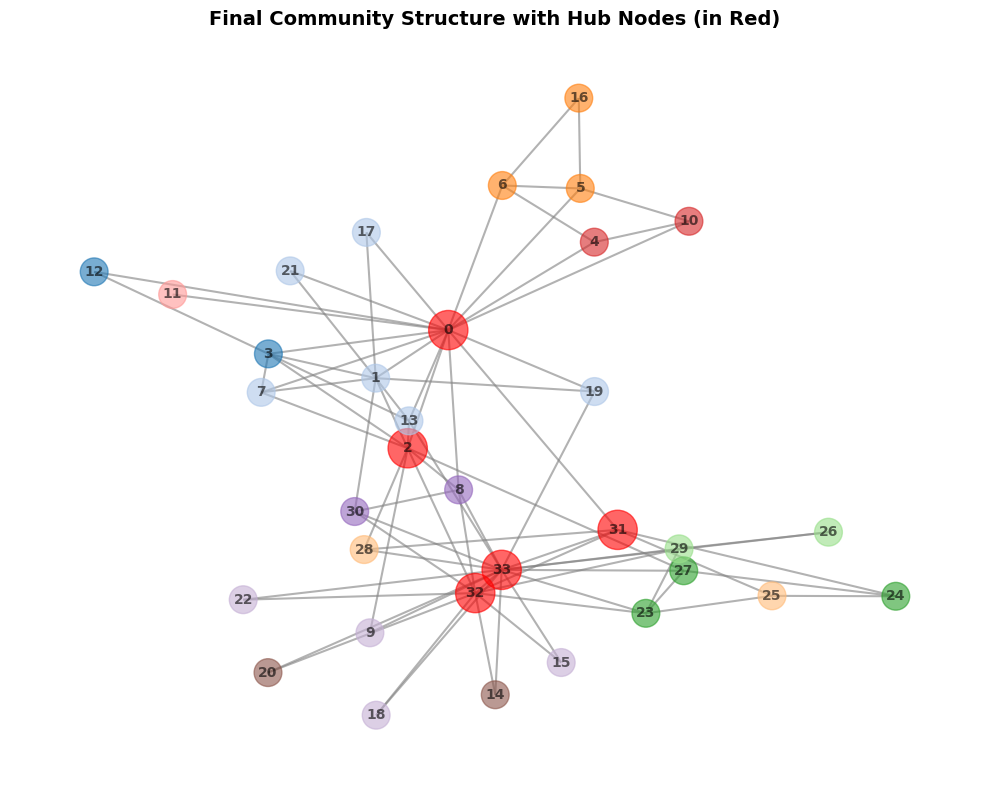

In [39]:


fig, ax = plt.subplots(figsize=(10, 8))


final_communities = final_comms

# Maping each node to its community index
node_to_community = {}
for comm_idx, community in enumerate(final_communities):
    for node in community:
        node_to_community[node] = comm_idx

cmap = plt.get_cmap("tab20")

node_colors = []
node_sizes = []

for node in G.nodes():
    comm = node_to_community.get(node, 0)
    if node in hub_nodes:
        node_colors.append("red")
        node_sizes.append(800)
    else:
        node_colors.append(cmap(comm % cmap.N))
        node_sizes.append(400)

nx.draw(G,pos,with_labels=True,node_color=node_colors,node_size=node_sizes,
    font_size=10,font_weight="bold",edge_color="gray",width=1.5,
    alpha=0.6,ax=ax,)

ax.set_title("Final Community Structure with Hub Nodes (in Red)",fontsize=14,fontweight="bold",)

ax.axis("off")
plt.tight_layout()
plt.show()


Based on Graph we can see that **Hub nodes** especially nodes 0 & 33  maintain high centrality regardless of partition.

___
# Discussion or **Report**

- ## Community Structure Findings

    - The recursive spectral modularity method partitions the Karate Club network into 11 communities, stopping when the leading eigenvalue λ₁ of the modularity matrix becomes non‑positive.
    - When the modularity matrix uses the total number of edges of the full graph instead of the subgraph, **the method yields two communities**, recovering the well‑known main split and showing how the **null model controls the resolution of detected groups**.

- ## Evolution of Modularity Score

    - The first split produces the largest increase in modularity, indicating that it captures the most prominent partition in the network.
    - 2 communities thus obtained also aligns with real world split, as people will either follow Mr. Hi or the Club President.
    - Splits up to the third iteration give smaller positive gains, so these refinements improve the partition but with diminishing returns.
    - After the third iteration, modularity decreases while remaining positive, meaning later splits over‑fragment the network and weaken the overall community structure compared to earlier, higher‑Q partitions.

    - ###   Conclusion
      - **Partitions till 3rd iteration were stronger and more meaningful communities**,

      - Beyond that **the community structure gets weaker than before**.
      
      - Partitions **near Q ≈ 0.4 are considered good**, and a monotonic decrease away from that value over iterations means **updates are moving away from the best-known community structure**.


- ## Consistently Central Nodes

    Based on the metric evolution analysis:

    1. **Degree Centrality**: High‑degree nodes act as stable hubs, remaining structurally important across all splits.

    2. **Betweenness Centrality**: Bridge nodes with high betweenness centrality lie near community boundaries and help explain how different communities remain connected.

    3. **Closeness Centrality**: central nodes stay close to the rest of the network

    4. **Clustering Coefficient**: Remains largely unchanged because it depends on local triangles rather than the chosen partition

- ## How Community Structure Influences Metrics

    - **During splits**, Bridge nodes show volatile betweenness during splits.
    - **Peripheral nodes** keep lower, stable centrality values.
    - **Hub nodes** retain high centrality across partitions.
    - The **clustering coefficient remains constant**, reflecting local triangles rather than the partition.

___
# References

    1. M. E. J. Newman, “Modularity and community structure in networks,” 
    Proceedings of the National Academy of Sciences, 103(23), 8577–8582, 2006.

    2. W. W. Zachary, “An information flow model for conflict and fission in small groups,” 
    Journal of Anthropological Research, 33(4), 452–473, 1977.

    3. NetworkX Developers, “NetworkX documentation: karate_club_graph,” 
    https://networkx.org/, accessed 2025.